## Document Scanning using skimage 

Add util folder to the path

In [1]:
%load_ext autoreload 
%autoreload 2
import sys

sys.path.append("../util")

import neccessary dependencies

In [2]:
from plot import plot_images
from skimage.io import imread
from skimage.transform import rescale
from skimage.morphology import closing
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt
import numpy as np

Read the image and scale it down to reduce computational expences

In [3]:
scaling_factor = .25
img_path = "../images/example_0.jpg"

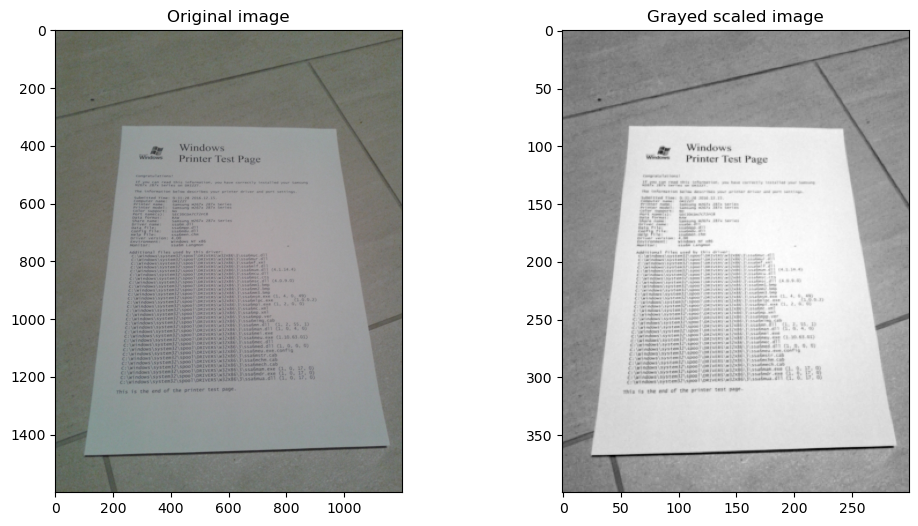

In [4]:
img = imread(img_path)
working_img = rescale(img, scaling_factor, channel_axis=2)
working_img = rgb2gray(working_img)

_ = plot_images([(img, "Original image"), (working_img, "Grayed scaled image", plt.cm.gray)], figsize=(12,6))

Use closing and gaussian blur as preprocessing steps to remove noise and thins like text

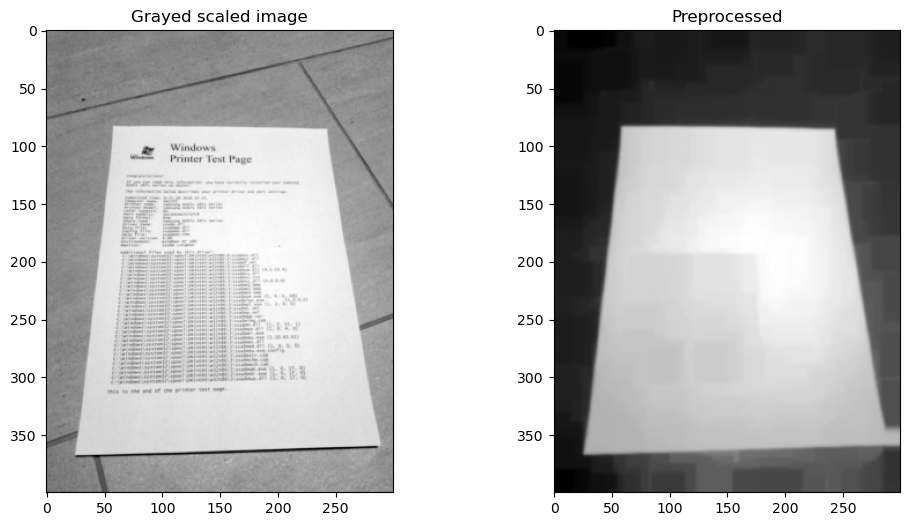

In [5]:
preprocess_img = closing(working_img, footprint=[(np.ones((27, 1)), 1), (np.ones((1, 27)), 1)])
preprocess_img = gaussian(preprocess_img, sigma=1.2)

_ = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (preprocess_img, "Preprocessed", plt.cm.gray)], figsize=(12,6))

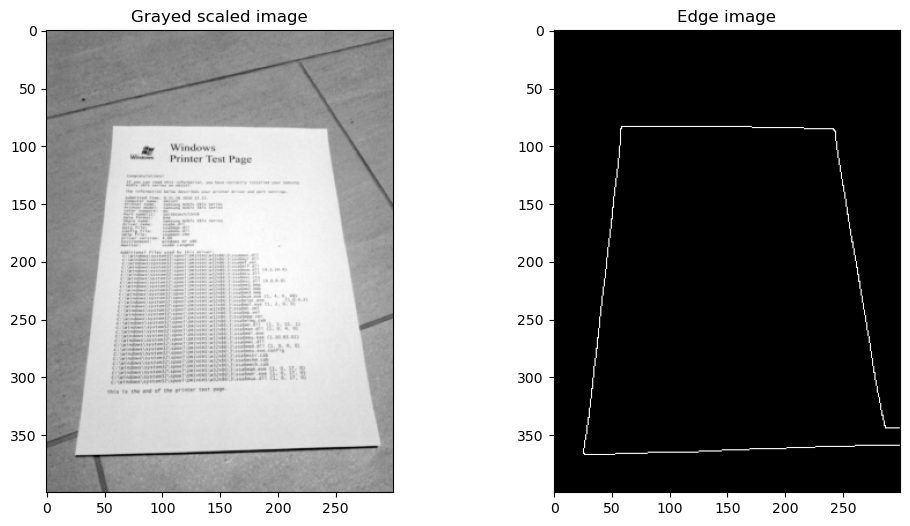

In [6]:
edge_image = canny(preprocess_img)

_ = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (edge_image, "Edge image", plt.cm.gray)], figsize=(12,6))

With the now final preprocessed image, use hough transform to find lines which would correspond to the edges of the document, in the image.

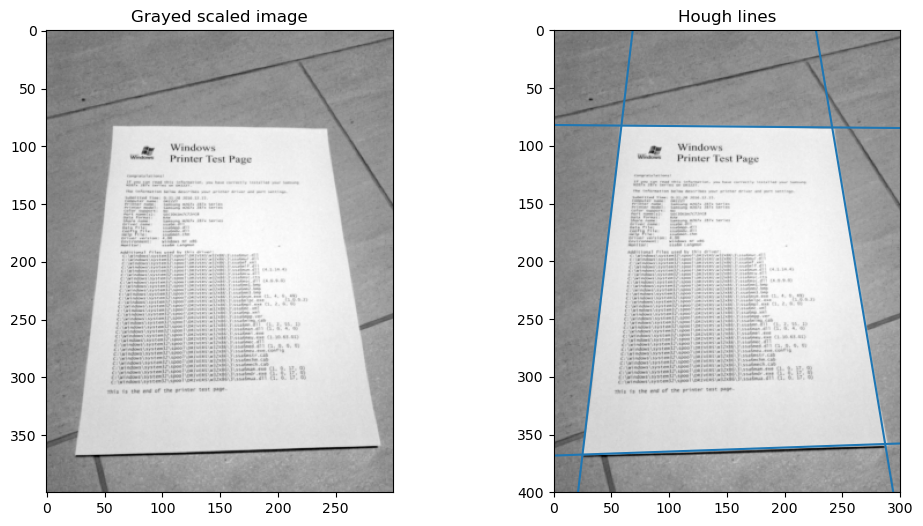

In [7]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 720, endpoint=False)
h, theta, d = hough_line(edge_image, theta=tested_angles)



fig, ax = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (working_img, "Hough lines", plt.cm.gray)], figsize=(12,6))

ax[1].set_xlim(0, working_img.shape[1])
ax[1].set_ylim(working_img.shape[0], 0)

hough_lines = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=4, threshold=.4*max([max(a) for a in h]))):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    slope = np.tan(angle + np.pi / 2)
    ax[1].axline((x0, y0), slope=slope)
    hough_lines.append((x0, y0, slope))

Finding the intersection points of the lines to define the rectangle

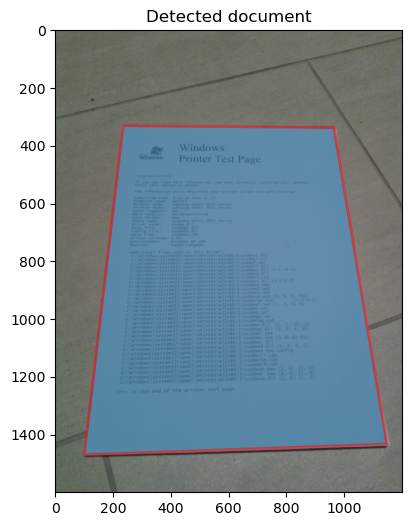

In [8]:
from geometry import line_intersections, rescale_point

intersections = line_intersections(hough_lines)

# filter intersection points that are either inside the image or within an epsilon margin defined as a percentage of the image dimensions. The epsilon value allows intersections
# near the image edges to be included.
epsilon = .1
epsilon_y, epsilon_x = epsilon * np.array(working_img.shape)
max_y, max_x = working_img.shape
max_y, max_x = max_y + epsilon_y, max_x + epsilon_x
intersections = [inter for inter in intersections if -epsilon_x <= inter[0][0] <= max_x and -epsilon_y <= inter[0][1] <= max_y ]


#get the corner points in counter clockwise order starting form 3. Quadrant (bottom left)
corners = [rescale_point(point[0], working_img.shape, img.shape[:-1]) for point in intersections]
corners_x, corners_y = np.array(list(zip(*corners)))
order = np.argsort(np.arctan2(corners_y - corners_y.mean(), corners_x - corners_x.mean()))

fig, ax = plot_images([(img, "Detected document", plt.cm.gray)], figsize=(12,6))
_ = ax[0].fill(corners_x[order], corners_y[order], fill="b", edgecolor="r", alpha= .5, linewidth=2)

Detect each corners position (top left, top right, ...)

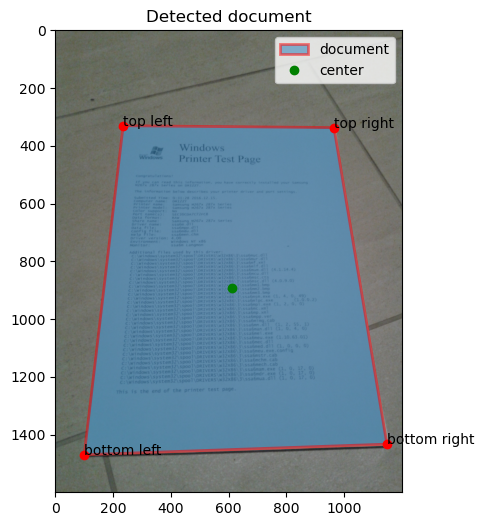

In [9]:
fig, ax = plot_images([(img, "Detected document", plt.cm.gray)], figsize=(12,6))
_ = ax[0].fill(corners_x[order], corners_y[order], fill="b", edgecolor="r", alpha= .5, linewidth=2,  label="document")

# order is bottom left counter clockwise but since the image positive y axis is facing downwards topleft is the first point here 
clockwise_corners = np.array(corners)[order]
labels = ["top left", "top right", "bottom right", "bottom left"]
for (x, y), label in zip(clockwise_corners, labels):
    ax[0].text(x, y, label)
    ax[0].plot(x, y, "ro")

center_y, center_x = corners_y.mean(), corners_x.mean()
ax[0].plot(center_x,center_y, 'go', label="center")
_= ax[0].legend()

Define width and height of the warped image

In [10]:
from geometry import euclidean_distance

top_left, top_right, bottom_right, bottom_left = clockwise_corners
horizontal_side_avg = np.average([euclidean_distance(top_left, top_right), euclidean_distance(bottom_left, bottom_right)])
vertical_side_avg = np.average([euclidean_distance(top_left, bottom_left), euclidean_distance(top_right, bottom_right)])

# find the shortest side and define this as the width. If the shortest side is the vertical the document must be rotated to get it in a portrait orientation
sides = [horizontal_side_avg, vertical_side_avg]
shortest_idx = np.argmin(sides)

width = sides[shortest_idx]
height = max(sides)

Warp the image to a top down perspective

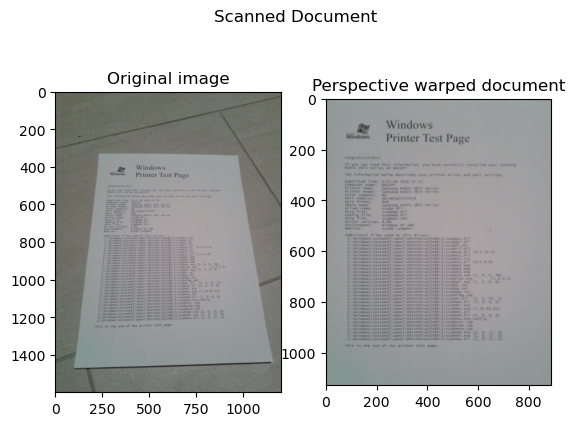

In [11]:
from skimage.transform import ProjectiveTransform, warp

# we need the counterclockwise order starting from bottom left so we need to reorder the clockwise corners which starts at top left
# deponing on the orientation of the document, choose the order accordingly
if shortest_idx == 1:
    fixed_order = [3, 2, 1, 0]
else: 
    fixed_order = [0, 3, 2, 1]
src = np.array([[0,0], [0, height], [width, height], [width, 0]])
dst = clockwise_corners[fixed_order]

tform3 = ProjectiveTransform()
tform3.estimate(src, dst)
warped = warp(img, tform3, output_shape=(int(height), int(width)))
warped = (warped * 255).astype(np.uint8)

_ = plot_images([(img, "Original image"), (warped, "Perspective warped document")], title="Scanned Document")

In [12]:
from skimage.io import imsave
from os import path


imsave(f"../out/{path.basename(img_path).split(".")[0]}_scanned_document.png", warped)